In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import re
import matplotlib.pyplot as plt
import os
import warnings
import plotly.express as px

In [2]:
def convert2Num(atribute, df):
    df[atribute] = [float(re.findall(r'\d+', df[atribute][k])[0]) if re.findall(r'\d+', df[atribute][k]) else 0 for k in range(len(df))]

In [3]:
def plotCountAndDistribution(data):
  with warnings.catch_warnings(record=True):
    f, axes = plt.subplots(1, 2, figsize=(20, 8))
    sns.countplot(data, ax=axes[0])
    sns.distplot(data, ax=axes[1])

In [4]:
def plot4Cols(df, col):
    days = df['Date'].unique()
    t_mean = [df[df.Date == d][col].mean() for d in days]
    # df2 = pd.DataFrame(list(zip(days, t_mean)), columns=['Day', 'T-Mean'])
    year = [np.datetime64(k, 'Y') for k in days]
    f = plt.figure()
    f.set_size_inches((12, 7))
    sns.lineplot(y = t_mean, x = days)

In [5]:
def topRainyMonths(HCM_df, N):
    rainyDays = HCM_df.groupby('Date').Label.max()
    rainyDays = pd.DataFrame(rainyDays)
    rainyDays.reset_index(inplace=True)

    rainyDays['Y-M'] = [str(k.year) + '-' + str(k.month) for k in rainyDays['Date']]
    # rainyDays['Year'] = [str(k.year) for k in rainyDays['Date']]
    top = rainyDays[rainyDays['Label']==1].groupby('Y-M').sum()
    top.reset_index(inplace=True)
    top['Year'] = [k.split('-')[0] for k in top['Y-M']]
    # top.sort_values(by=['Label'], ascending=False)['Label'].head(10).plot(kind='bar')
    plt.figure(figsize=(12,6))
    top = top.sort_values(by='Label', ascending=False).head(N)
    sns.barplot(data = top, y='Label', x = 'Y-M', palette='pastel', hue='Year', dodge=False)

In [6]:
def rainyDaysInMonth(HCM_df, year):
    grouped = HCM_df.groupby(HCM_df['Year'])
    df = grouped.get_group(year)
    topRainyMonths(df, 12)

In [7]:
def PLotMinMax(HCM_df, col):
    days = list(HCM_df['Date'].unique())
    t_max = [HCM_df[HCM_df.Date == d][col].max() for d in days]
    t_min = [HCM_df[HCM_df.Date == d][col].min() for d in days]
    # t_mean = [HCM_df[HCM_df.Date == d]['Temperature(°C)'].mean() for d in days]

    plt.figure(figsize = (20,8))
    dt = pd.DataFrame({'Max':t_max, 'Min':t_min, 'Date': days})
    fig = px.line(dt, x='Date', y=['Max', 'Min']) # 'Mean':t_mean,

    fig.update_layout(
        title=col+" Plot",
        xaxis_title="Days",
        yaxis_title=col,
        legend_title="Note",
        font=dict(
            family="Courier New, monospace",
            size=18))

    fig.show()

In [17]:
def formatDate(HCM_df):
    # Changing Formatted Date from String to Datetime
    t = [str(HCM_df['Year'][k]) + '-' + str(HCM_df['Month'][k]) + '-' + str(HCM_df['Day'][k]) + ' ' + str(HCM_df['Time'][k]) for k in range(len(HCM_df))]
    HCM_df['Formatted Date'] = pd.to_datetime(t, utc=True)

    d=[str(HCM_df['Year'][k]) + '-' + str(HCM_df['Month'][k]) + '-' + str(HCM_df['Day'][k]) for k in range(len(HCM_df))]
    HCM_df['Date'] = pd.to_datetime(d, format='%Y-%m-%d')
    HCM_df = HCM_df.sort_values(by='Formatted Date')

    RAIN_LABEL = ['Light drizzle','Light rain','Light rain shower', 'Patchy light drizzle', 'Patchy light rain', 
                'Patchy light rain with thunder','Patchy rain possible','Heavy rain','Heavy rain at times',
                'Moderate or heavy rain shower','Moderate rain', 'Moderate rain at times', 'Overcast','Torrential rain shower']
    tmp = []
    for i, value in enumerate(HCM_df['Weather']):
        if value in RAIN_LABEL:
            tmp.append(1)
        else:
            tmp.append(0)
    HCM_df['Label'] = tmp
    # HCM_df.reset_index(inplace=True)
    return HCM_df

In [37]:
def compareWithNational(VN_df, prv, col):
    ls = []
    days = VN_df['Date'].unique()
    m = []
    for c in province:
        grouped = VN_df.groupby(VN_df['Province'])
        df = grouped.get_group(c)  
        if c == prv:
            m = [df[df.Date == d][col].mean() for d in days]
        t_mean = [df[df.Date == d][col].mean() for d in days]
        ls.append(t_mean)

    mean_prv=np.mean(np.array(ls), axis = 0)
    year = [np.datetime64(k, 'Y') for k in days]


    plt.figure(figsize = (20,10))
    dt = pd.DataFrame({prv:m, 'VN':mean_prv, 'Date': days}) #np.arange(VN_df[col].min(),VN_df[col].max()) 
    fig = px.line(dt, x='Date', y=[prv, 'VN']) # 'Mean':t_mean,

    fig.update_layout(
        title='Compare the national average '+ col +  ' with ' + prv,
        xaxis_title="Days",
        yaxis_title=col,
        legend_title="Note",
        font=dict(
            family="Courier New, monospace",
            size=18))

    fig.show()

In [19]:
HCM_df = pd.read_csv("weather_data/weather_data_hcm_[2017-2022]_clean.csv")
HCM_df.rename(columns = {'Humidity':'Humidity(%)', 'Dew point': 'Dew point(°C)', 'Temperature': 'Temperature(°C)', 'Rain': 'Rain(mm)', 'Cloud': 'Cloud(%)', 'Pressure': 'Pressure(mb)', 'Wind':'Wind(km/h)', 'Gust': 'Gust(km/h)', 'Dir': 'Dir(DEG)'}, inplace = True)

cols = ['Humidity(%)', 'Dew point(°C)',
        'Rain(mm)', 'Cloud(%)', 'Pressure(mb)',
        'Wind(km/h)', 'Gust(km/h)', 'Dir(DEG)']
for col in cols:
    convert2Num(col, HCM_df)

HCM_df.shape
HCM_df.tail()
# HCM_df.apply(lambda x: x.isnull().sum())


,Time,Day,Month,Year,Humidity(%),Dew point(°C),Temperature(°C),Rain(mm),Cloud(%),Pressure(mb),Wind(km/h),Gust(km/h),Dir(DEG),Weather
14256,09:00,31,12,2019,70.0,23.0,32.0,0.0,4.0,1016.0,9.0,11.0,33.0,Clear
14257,12:00,31,12,2019,49.0,20.0,34.0,0.0,14.0,1013.0,7.0,8.0,59.0,Clear
14258,15:00,31,12,2019,36.0,17.0,33.0,0.0,11.0,1011.0,9.0,11.0,104.0,Clear
14259,18:00,31,12,2019,59.0,21.0,27.0,0.0,7.0,1013.0,12.0,15.0,134.0,Clear
14260,21:00,31,12,2019,51.0,18.0,26.0,0.0,13.0,1016.0,10.0,15.0,99.0,Clear


In [20]:
HCM_df = formatDate(HCM_df)
HCM_df.tail()

,Time,Day,Month,Year,Humidity(%),Dew point(°C),Temperature(°C),Rain(mm),Cloud(%),Pressure(mb),Wind(km/h),Gust(km/h),Dir(DEG),Weather,Formatted Date,Date,Label
7212,09:00,30,6,2022,89.0,28.0,28.0,0.0,42.0,1005.0,14.0,19.0,260.0,Partly cloudy,2022-06-30 09:00:00+00:00,2022-06-30,0
7213,12:00,30,6,2022,67.0,26.0,30.0,0.0,72.0,1004.0,15.0,26.0,260.0,Light rain shower,2022-06-30 12:00:00+00:00,2022-06-30,1
7214,15:00,30,6,2022,70.0,23.0,31.0,0.0,51.0,1002.0,15.0,22.0,259.0,Light rain shower,2022-06-30 15:00:00+00:00,2022-06-30,1
7215,18:00,30,6,2022,84.0,24.0,28.0,0.0,70.0,1003.0,11.0,18.0,230.0,Light rain shower,2022-06-30 18:00:00+00:00,2022-06-30,1
7216,21:00,30,6,2022,89.0,25.0,27.0,0.0,57.0,1005.0,12.0,21.0,266.0,Light rain shower,2022-06-30 21:00:00+00:00,2022-06-30,1


In [21]:
HCM_df.describe()

,Day,Month,Year,Humidity(%),Dew point(°C),Temperature(°C),Rain(mm),Cloud(%),Pressure(mb),Wind(km/h),Gust(km/h),Dir(DEG),Label
count,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000
mean,15.760956,6.291845,2019.359231,76.956525,23.476334,28.620994,0.652409,40.669659,1009.312250,9.982961,13.964519,168.298366,0.359021
std,8.744961,3.480716,1.655681,16.503357,2.566469,3.398173,2.204929,25.901438,2.320114,4.658573,6.820993,82.514464,0.479730
min,1.000000,1.000000,2017.000000,19.000000,7.000000,16.000000,0.000000,0.000000,1001.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,3.000000,2018.000000,66.000000,22.000000,26.000000,0.000000,19.000000,1008.000000,7.000000,9.000000,118.000000,0.000000
50%,16.000000,6.000000,2020.000000,79.000000,24.000000,28.000000,0.000000,36.000000,1009.000000,9.000000,13.000000,157.000000,0.000000
75%,23.000000,9.000000,2021.000000,89.000000,25.000000,31.000000,0.000000,61.000000,1011.000000,13.000000,18.000000,233.000000,1.000000
max,31.000000,12.000000,2022.000000,100.000000,29.000000,39.000000,101.000000,100.000000,1018.000000,33.000000,55.000000,360.000000,1.000000


<AxesSubplot:xlabel='Date', ylabel='Temperature(°C)'>

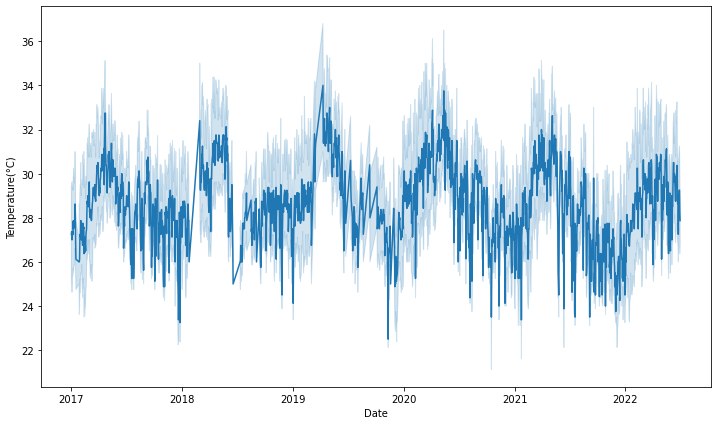

In [22]:
f = plt.figure()
f.set_size_inches((12, 7))
sns.lineplot(y = HCM_df['Temperature(°C)'], x = HCM_df['Date'])

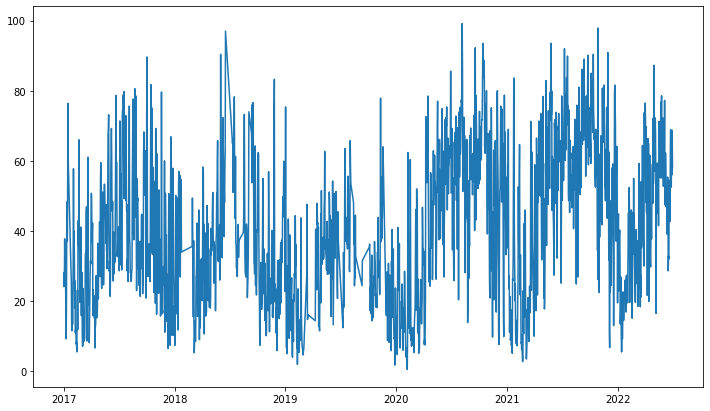

In [23]:
plot4Cols(HCM_df, cols[3]) # ['Humidity(%)', 'Dew point(°C)', 'Rain(mm)', 'Cloud(%)', 'Pressure(mb)', 'Wind(km/h)', 'Gust(km/h)', 'Dir(DEG)']

0    9141
1    5120
Name: Label, dtype: int64


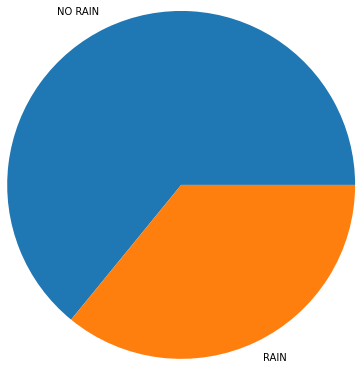

In [24]:
values = HCM_df['Label'].value_counts()
labels = HCM_df['Label'].unique().tolist()

plt.pie(values, labels = ['NO RAIN', 'RAIN'], radius=2)
plt.show
print(values)

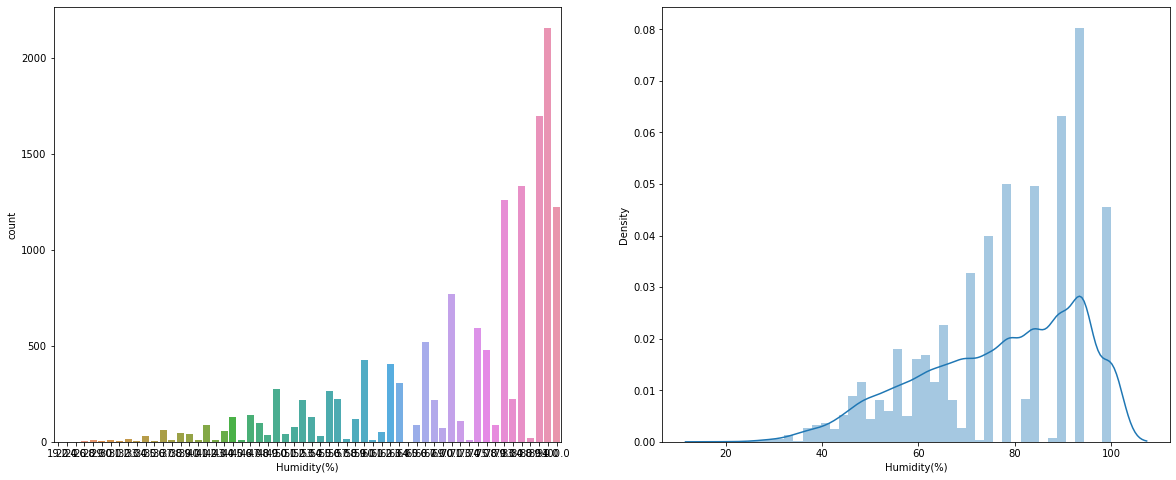

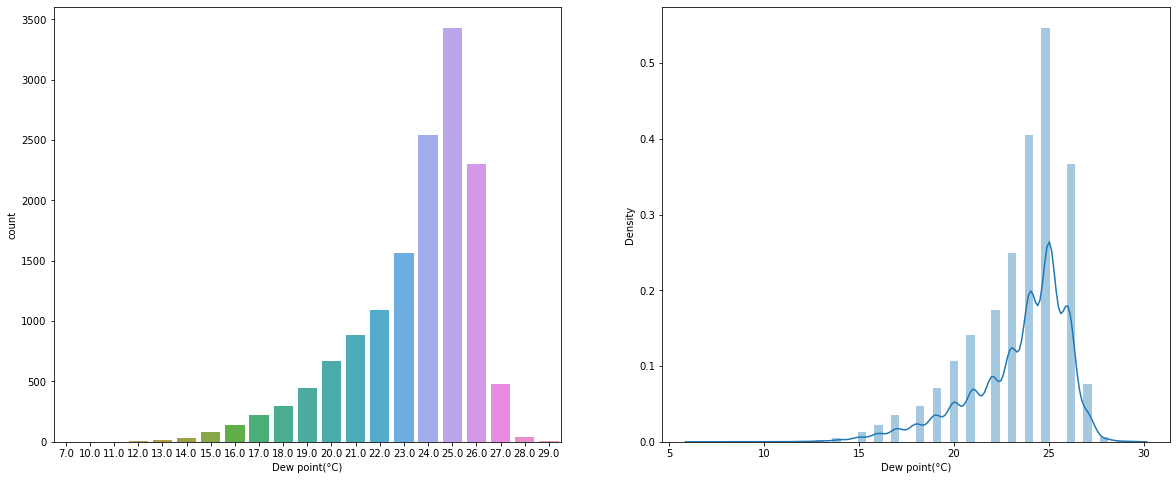

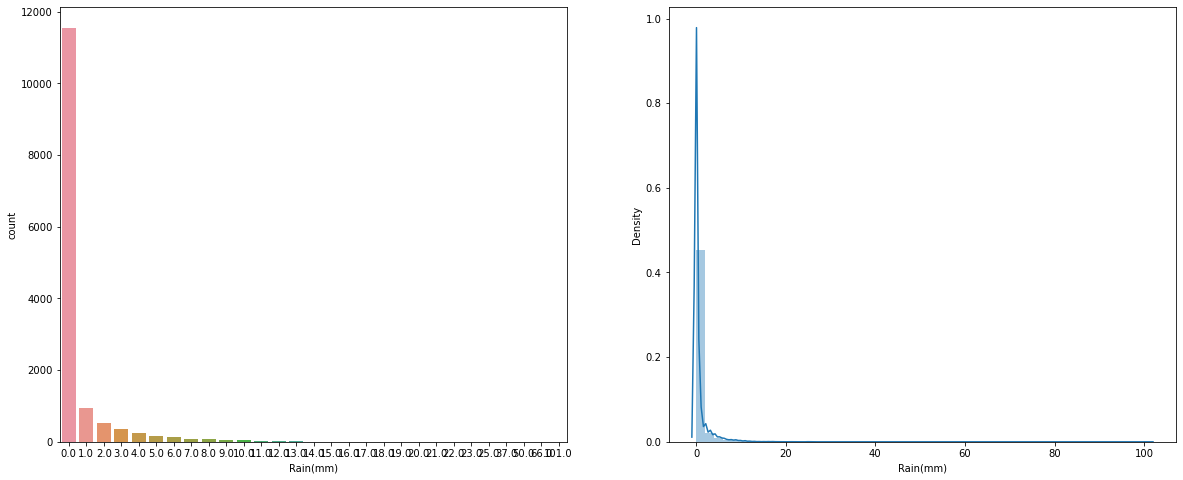

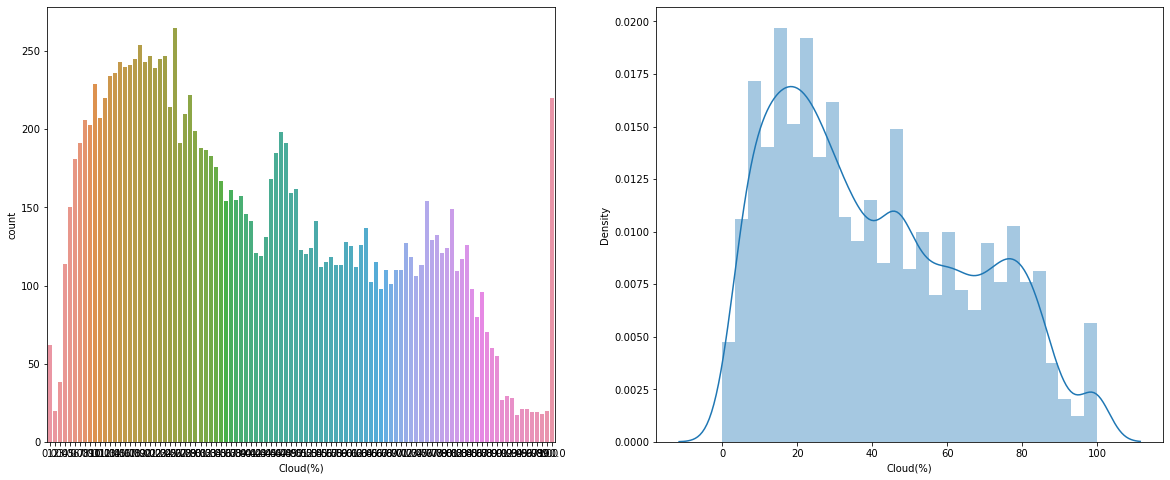

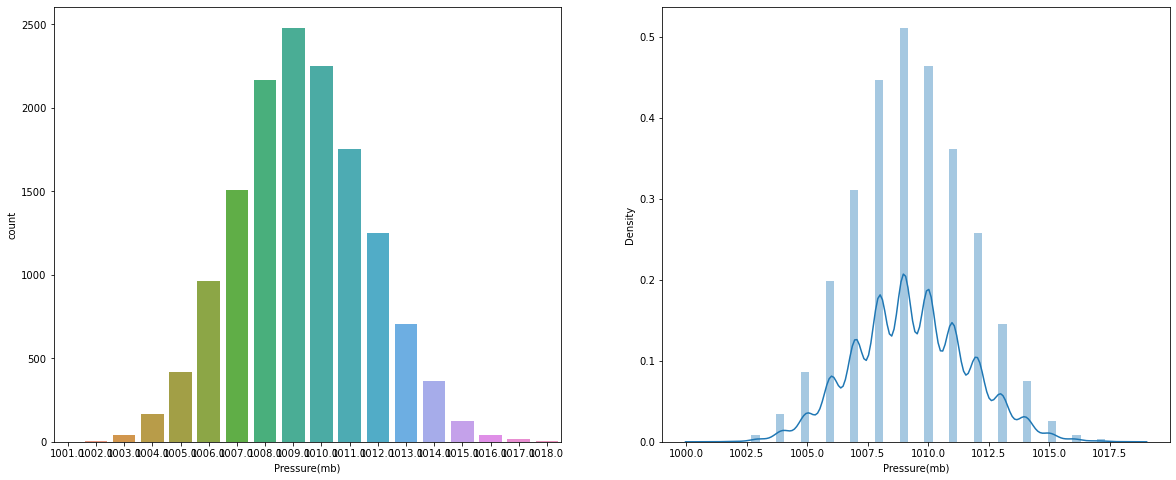

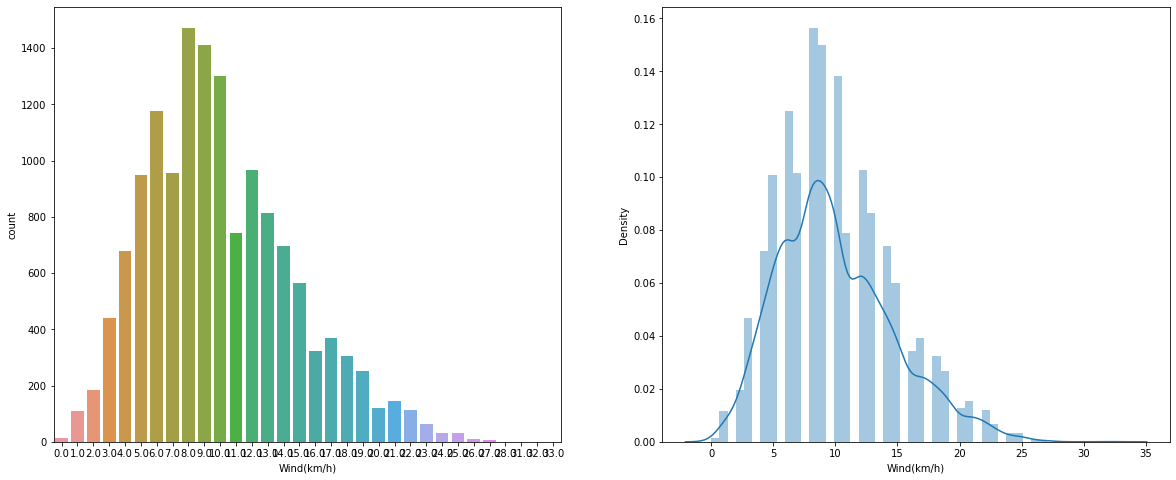

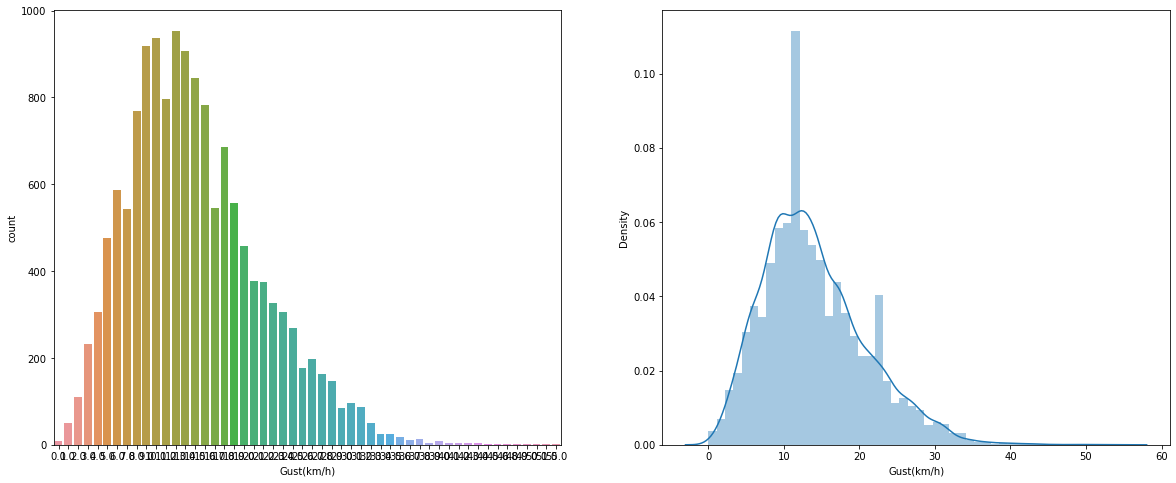

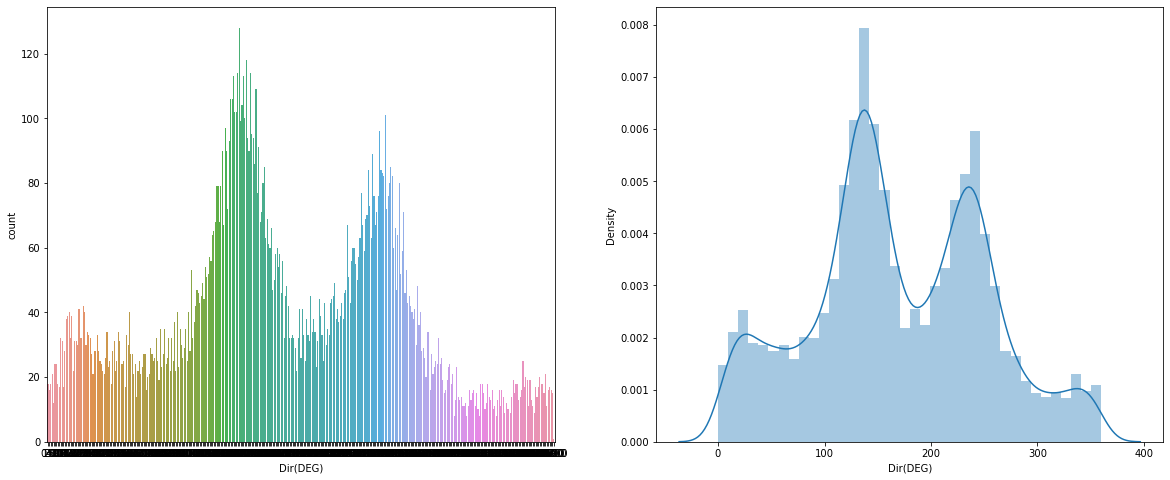

In [25]:
for c in cols:
  plotCountAndDistribution(HCM_df[c])

<AxesSubplot:>

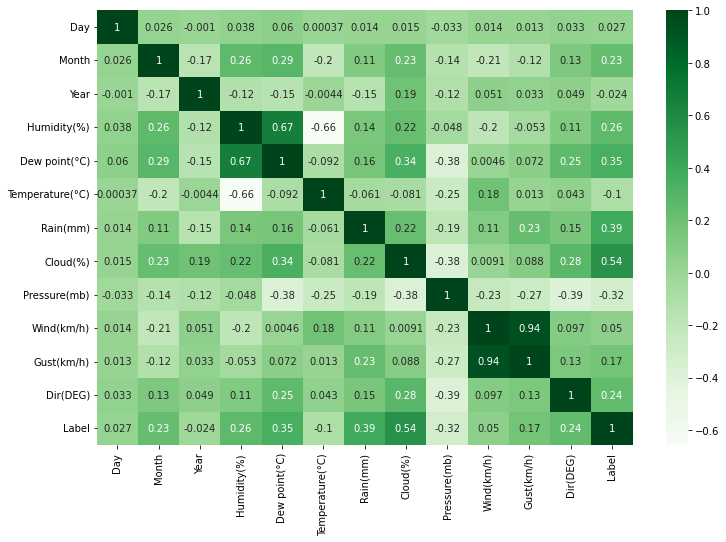

In [26]:
plt.figure(figsize = (12,8))
sns.heatmap(data=HCM_df.corr(), annot=True, cmap='Greens')

#### Top 10 rainy months from 2017-2022

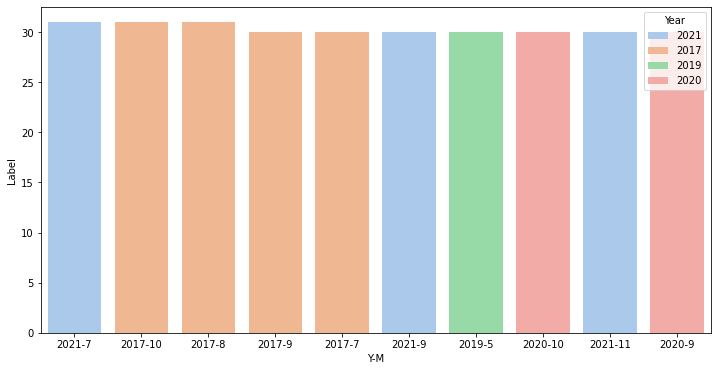

In [27]:
topRainyMonths(HCM_df, 10)

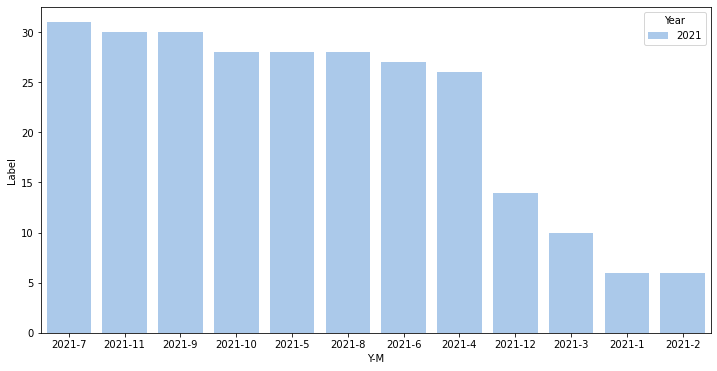

In [28]:
rainyDaysInMonth(HCM_df, 2021)

In [29]:
HCM_df.columns

Index(['Time', 'Day', 'Month', 'Year', 'Humidity(%)', 'Dew point(°C)',
       'Temperature(°C)', 'Rain(mm)', 'Cloud(%)', 'Pressure(mb)', 'Wind(km/h)',
       'Gust(km/h)', 'Dir(DEG)', 'Weather', 'Formatted Date', 'Date', 'Label'],
      dtype='object')

In [30]:
PLotMinMax(HCM_df, 'Temperature(°C)')

<Figure size 1440x576 with 0 Axes>

### VIET NAM DATA

In [ ]:
# df = pd.read_csv('weather_data/Vietnam/weather_data_VietNam_[2021].csv')
# df['Temperature'] = [float(k.split(' ')[0]) for k in df['Temperature']]
# df
# convert2Num('Temperture', df)

In [31]:
path = 'weather_data/Vietnam/'
entries = os.listdir(path)
VN_df = pd.DataFrame()
for entry in entries:
    df = pd.read_csv(path + entry)
    if(type(df['Temperature'][0]) == str):
        df['Temperature'] = [float(k.split(' ')[0]) for k in df['Temperature']]
    VN_df = pd.concat([VN_df, df], ignore_index=True)
VN_df.rename(columns = {'year':'Year', 'Humidity':'Humidity(%)', 'Dew point': 'Dew point(°C)', 'Temperature': 'Temperature(°C)', 'Rain': 'Rain(mm)', 'Cloud': 'Cloud(%)', 'Pressure': 'Pressure(mb)', 'Wind':'Wind(km/h)', 'Gust': 'Gust(km/h)', 'Dir': 'Dir(DEG)'}, inplace = True)
VN_df

,Time,Day,Month,Year,Humidity(%),Dew point(°C),Province,Temperature(°C),Rain(mm),Cloud(%),Pressure(mb),Wind(km/h),Gust(km/h),Dir(DEG),Weather
0,0:00,1,1,2017,94.0,24.0,Tây Ninh,23.0,0.0,10.0,1012.0,11.0,20.0,16.2,Clear
1,3:00,1,1,2017,100.0,24.0,Tây Ninh,23.0,0.0,4.0,1012.0,11.0,18.0,20.0,Clear
2,6:00,1,1,2017,100.0,23.0,Tây Ninh,23.0,0.0,5.0,1013.0,11.0,17.0,16.3,Clear
3,9:00,1,1,2017,66.0,21.0,Tây Ninh,28.0,0.0,6.0,1013.0,20.0,23.0,25.1,Clear
4,12:00,1,1,2017,49.0,20.0,Tây Ninh,33.0,0.0,34.0,1011.0,19.0,22.0,43.8,Partly cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805019,9:00,31,12,2021,62.0,20.0,Bến Tre,26.0,0.0,12.0,1014.0,9.0,11.0,32.3,Clear
805020,12:00,31,12,2021,43.0,18.0,Bến Tre,34.0,0.0,8.0,1012.0,8.0,9.0,36.2,Clear
805021,15:00,31,12,2021,41.0,18.0,Bến Tre,30.0,0.0,37.0,1011.0,8.0,9.0,63.1,Partly cloudy
805022,18:00,31,12,2021,55.0,19.0,Bến Tre,25.0,0.0,23.0,1012.0,8.0,13.0,124.5,Clear


In [32]:
VN_df = formatDate(VN_df)
VN_df.tail()

,Time,Day,Month,Year,Humidity(%),Dew point(°C),Province,Temperature(°C),Rain(mm),Cloud(%),Pressure(mb),Wind(km/h),Gust(km/h),Dir(DEG),Weather,Formatted Date,Date
805019,9:00,31,12,2021,62.0,20.0,Bến Tre,26.0,0.0,12.0,1014.0,9.0,11.0,32.3,Clear,2021-12-31 09:00:00+00:00,2021-12-31
805020,12:00,31,12,2021,43.0,18.0,Bến Tre,34.0,0.0,8.0,1012.0,8.0,9.0,36.2,Clear,2021-12-31 12:00:00+00:00,2021-12-31
805021,15:00,31,12,2021,41.0,18.0,Bến Tre,30.0,0.0,37.0,1011.0,8.0,9.0,63.1,Partly cloudy,2021-12-31 15:00:00+00:00,2021-12-31
805022,18:00,31,12,2021,55.0,19.0,Bến Tre,25.0,0.0,23.0,1012.0,8.0,13.0,124.5,Clear,2021-12-31 18:00:00+00:00,2021-12-31
805023,21:00,31,12,2021,58.0,18.0,Bến Tre,25.0,0.0,39.0,1014.0,9.0,14.0,95.0,Partly cloudy,2021-12-31 21:00:00+00:00,2021-12-31


In [33]:
VN_df.describe()

,Day,Month,Year,Humidity(%),Dew point(°C),Temperature(°C),Rain(mm),Cloud(%),Pressure(mb),Wind(km/h),Gust(km/h),Dir(DEG)
count,805024.000000,805024.000000,805024.000000,805024.000000,805024.000000,805024.000000,805024.000000,805024.000000,805024.000000,805024.000000,805024.000000,805024.000000
mean,15.785616,6.604967,2019.060450,78.483636,22.004980,25.323010,0.781255,48.209133,1010.705574,10.164526,14.833237,155.634285
std,8.746878,3.491668,1.474843,16.243437,4.617877,5.010782,2.633938,30.876573,5.127206,5.850136,8.364092,90.494812
min,1.000000,1.000000,2017.000000,18.000000,-7.000000,-2.000000,0.000000,0.000000,987.000000,0.000000,0.000000,0.000000
25%,8.000000,4.000000,2018.000000,66.000000,20.000000,22.000000,0.000000,20.000000,1007.000000,6.000000,9.000000,86.500000
50%,16.000000,7.000000,2019.000000,82.000000,24.000000,26.000000,0.000000,45.000000,1010.000000,9.000000,14.000000,139.400000
75%,23.000000,10.000000,2020.000000,94.000000,25.000000,29.000000,0.500000,75.000000,1014.000000,13.000000,19.000000,227.200000
max,31.000000,12.000000,2021.000000,135.000000,32.000000,45.000000,243.400000,100.000000,1036.000000,83.000000,148.000000,360.000000


In [34]:
province = list(VN_df.Province.unique())

In [35]:
grouped = VN_df.groupby(VN_df['Province'])
HCM_df = grouped.get_group('Thành phố Hồ Chí Minh')
HCM_df.head()

,Time,Day,Month,Year,Humidity(%),Dew point(°C),Province,Temperature(°C),Rain(mm),Cloud(%),Pressure(mb),Wind(km/h),Gust(km/h),Dir(DEG),Weather,Formatted Date,Date
70143,0:00,1,1,2017,94.0,24.0,Thành phố Hồ Chí Minh,24.0,0.0,4.0,1012.0,8.0,12.0,58.7,Clear,2017-01-01 00:00:00+00:00,2017-01-01
70144,3:00,1,1,2017,100.0,24.0,Thành phố Hồ Chí Minh,24.0,0.0,4.0,1011.0,8.0,10.0,42.2,Clear,2017-01-01 03:00:00+00:00,2017-01-01
70145,6:00,1,1,2017,100.0,23.0,Thành phố Hồ Chí Minh,24.0,0.0,7.0,1012.0,8.0,11.0,22.4,Clear,2017-01-01 06:00:00+00:00,2017-01-01
70146,9:00,1,1,2017,66.0,21.0,Thành phố Hồ Chí Minh,29.0,0.0,6.0,1012.0,11.0,13.0,26.6,Clear,2017-01-01 09:00:00+00:00,2017-01-01
70147,12:00,1,1,2017,49.0,20.0,Thành phố Hồ Chí Minh,32.0,0.0,53.0,1010.0,10.0,12.0,56.9,Partly cloudy,2017-01-01 12:00:00+00:00,2017-01-01


<AxesSubplot:xlabel='Date', ylabel='Temperature(°C)'>

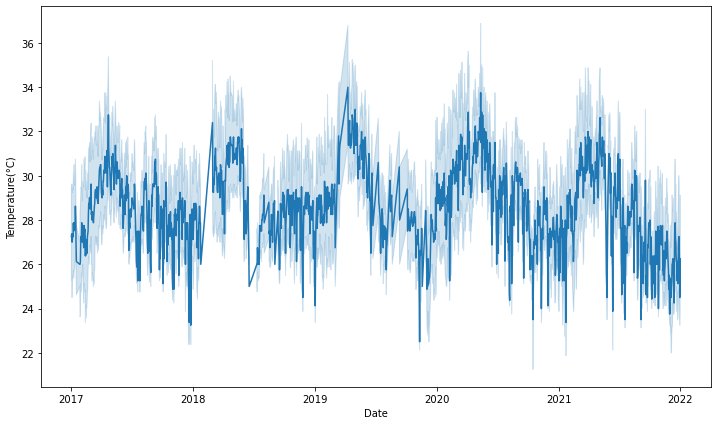

In [36]:
f = plt.figure()
f.set_size_inches((12, 7))
sns.lineplot(y = HCM_df['Temperature(°C)'], x = HCM_df['Date'])

In [42]:
compareWithNational(VN_df, 'Thành phố Hồ Chí Minh','Humidity(%)')

<Figure size 1440x720 with 0 Axes>

In [41]:
VN_df.columns

Index(['Time', 'Day', 'Month', 'Year', 'Humidity(%)', 'Dew point(°C)',
       'Province', 'Temperature(°C)', 'Rain(mm)', 'Cloud(%)', 'Pressure(mb)',
       'Wind(km/h)', 'Gust(km/h)', 'Dir(DEG)', 'Weather', 'Formatted Date',
       'Date'],
      dtype='object')